In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import muon
import ott
import functools
import logging
import typing as t

import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import scanpy as sc
import scipy.sparse as sp
import scipy.stats as ss
from ott.geometry import costs, geometry, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from sklearn import metrics, model_selection
from ott.geometry import costs as sparse_costs

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [5]:
adata = mudata["rna"]
adata = adata[adata.obs["cell_type"].isin(endocrine_celltypes)]


In [6]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

adata.obs['time'] = adata.obs.apply(adapt_time, axis=1).astype("category")

/tmp/ipykernel_2050456/440930313.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['time'] = adata.obs.apply(adapt_time, axis=1).astype("category")


In [7]:
adata = adata[adata.obs["time"].isin((15.5, 16.5))]

In [8]:
adata.X = adata.layers["raw_counts"]

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
sc.pp.highly_variable_genes(adata, inplace=True, subset=True)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [11]:
adata

AnnData object with n_obs × n_vars = 6810 × 2551
    obs: 'sample', 'name', 'stage', 'stage_num', 'int_id', 'seq_id_gex_id', 'seq_id_atac', 'reporter', 'experiment_batch', 'sequencing_batch', 'n_counts', 'log_counts', 'n_counts_rank', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'final_doublets', 'final_doublets_cat', 'doublet_calls', 'batch', 'size_factors', 'leiden', 'leiden_05_rna', 'leiden_05_atac', 'leiden_1_rna', 'leiden_1_atac', 'leiden_combined', 'leiden_gex_graph', 'leiden_ATAC_graph', 'leiden_wnn_graph', 'cell_type', 'cell_type_refined', 'S_score', 'G2M_score', 'phase', 'proliferation', 'time'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'ambient_genes_E14_5-0', 'is_ambient_E14_5-0', 'n_counts-0', 'n_counts-1', 'ambient_genes_E15_5-1', 'is_ambient_E15_5-1', 'n_counts-2', 'ambient_genes_NVF_E15-5_Rep2-2', 'is_ambient_NVF_E15-5_Rep2-2', 'n_counts-3', 'ambient_genes_NVF_E16-5_Rep1-3', 'is_ambient_NVF_E16-5_Rep1-3', 'is_ambient', 'n_counts', 'n_cells'

In [12]:
gex_early = adata[adata.obs["time"]==15.5].X.A
gex_late = adata[adata.obs["time"]==16.5].X.A

In [13]:
x=gex_early
y=gex_late

In [14]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, batch_size=1)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [15]:
map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg=50.0))

In [16]:
from tqdm import tqdm
batch_size=64
push_forward = []
for i in tqdm(range(0, len(x), batch_size)):
    push_forward.append(map_l1(x[i:i+batch_size]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [2:27:42<00:00, 110.78s/it]


In [17]:
ls_flattened=[]
for el in push_forward:
    ls_flattened.extend(el)

In [18]:
res=np.asarray(ls_flattened)

In [19]:
np.save("elastic_l1_50.npy", res)

In [20]:
gene_mask = (np.abs(res-x) > 1e-6)

In [21]:
adata_15 = adata[adata.obs["time"].isin((15.5, ))]

In [22]:
adata_15.layers["sparse_mask"] = gene_mask

/tmp/ipykernel_2050456/1174042063.py:1: ImplicitModificationWarning: Setting element `.layers['sparse_mask']` of view, initializing view as actual.
  adata_15.layers["sparse_mask"] = gene_mask


In [23]:
adata_15.var["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=0)
adata_15.obs["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=1)

In [24]:
adata_15.var["sparse_counts"].sort_values()[-5:]/len(adata_15)

Igfbpl1    0.065638
Mdk        0.079312
Mfap4      0.088494
Rpl35      0.148271
Gm10076    0.207267
Name: sparse_counts, dtype: float64

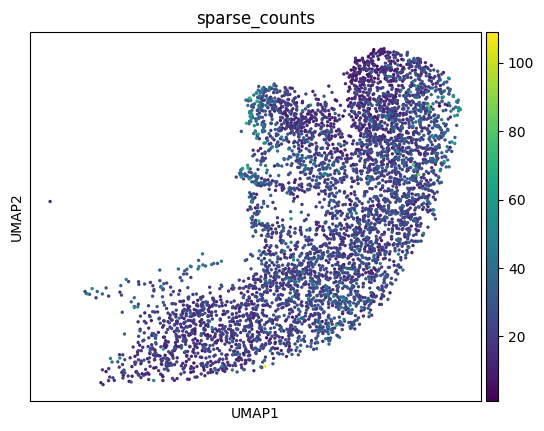

In [25]:
sc.pl.umap(adata_15, color='sparse_counts')

In [26]:
res_dict = {}
res_dict_2 = {}
for cell_type in endocrine_celltypes:
    adata_tmp = adata_15[adata_15.obs["cell_type"]==cell_type]
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    adata_tmp.obs["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=1)
    res_dict[cell_type] = adata_tmp.var["sparse_counts"].sort_values()[-5:]/len(adata_tmp)
    res_dict_2[cell_type] = (adata_tmp.var["sparse_counts"]/len(adata_tmp)).var()

/tmp/ipykernel_2050456/2226181577.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)


In [27]:
res_dict

{'Ngn3 low': Id1        0.158784
 Col2a1     0.189189
 Vim        0.197635
 Rpl35      0.447635
 Gm10076    0.488176
 Name: sparse_counts, dtype: float64,
 'Ngn3 high': Igfbpl1    0.156408
 Mdk        0.162201
 Mfap4      0.196959
 Rpl35      0.204200
 Gm10076    0.273715
 Name: sparse_counts, dtype: float64,
 'Fev+': Pou3f4    0.080672
 Bex2      0.095798
 Lrp1b     0.097479
 Pcdh9     0.104202
 Ffar2     0.151261
 Name: sparse_counts, dtype: float64,
 'Fev+ Alpha': Cldn4      0.136691
 Bex2       0.151079
 Gm10076    0.179856
 Ffar2      0.215827
 Arx        0.266187
 Name: sparse_counts, dtype: float64,
 'Fev+ Beta': Rnf165     0.050441
 Ambp       0.051702
 Rpl35      0.070618
 Pdx1       0.070618
 Gm10076    0.114754
 Name: sparse_counts, dtype: float64,
 'Fev+ Delta': Igfbpl1    0.151515
 Mfap4      0.159091
 Cdkn1a     0.181818
 Gm10076    0.181818
 Mdk        0.234848
 Name: sparse_counts, dtype: float64,
 'Eps. progenitors': Igfbpl1    0.191919
 Btbd17     0.191919
 Mfap4     

In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(res_dict_2, orient="index")#.sort_values("score")

In [29]:

df.sort_values(0)

,0
Beta,0.000041
Fev+ Beta,0.000046
Alpha,0.000077
Fev+,0.000107
Delta,0.000166
Ngn3 high,0.000210
Fev+ Delta,0.000236
Fev+ Alpha,0.000241
Epsilon,0.000337
Ngn3 low,0.000390


In [31]:
sc.pp.pca(adata_15)
sc.pp.neighbors(adata_15, n_neighbors=10)

In [32]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

js = []
for i in tqdm(range(len(adata_15))):
    neighbors = (adata_15.obsp["connectivities"][i]>0).T
    adata_cell = adata_15[i]
    adata_tmp = adata_15[list(neighbors.A[:,0])]   
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    genes_neighborhood = adata_tmp.var["sparse_counts"][adata_tmp.var["sparse_counts"]>0].index
    genes_cell = adata_cell.var["sparse_counts"][adata_cell.var["sparse_counts"]>0].index
    js.append(jaccard_similarity(set(genes_neighborhood), set(genes_cell)))
    
    

  0%|                                                                                                                                                            | 0/5119 [00:00<?, ?it/s]/tmp/ipykernel_2050456/1385431841.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5119/5119 [02:10<00:00, 39.16it/s]


In [33]:
adata_15.obs["js_inv"] = 1-np.asarray(js)

In [34]:
adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")

/tmp/ipykernel_2050456/2605882233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")


,js_inv
cell_type_refined,
Fev+ Alpha,0.894602
Delta,0.897988
Fev+,0.902303
Fev+ Beta,0.903440
Alpha,0.905177
Fev+ Delta,0.913614
Epsilon,0.914780
Ngn3 high,0.914854
Beta,0.917621
